In [1]:
from keras_facenet import FaceNet

from mtcnn.mtcnn import MTCNN

from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image,ImageDraw
from PIL import ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
embedder = FaceNet()
detector = MTCNN()

In [3]:
def extraction_keras_lock(*file_name,show=None):
  if type(file_name) is tuple:
    file_name = [*file_name,]
  result = []
  for i in file_name:
    image = Image.open(i).convert('RGB')
    im_arr = np.array(image)
    N=0
    faces = detector.detect_faces(im_arr)
    x1,y1,width,height = faces[N]['box'] # faces[N]['box']
    x2,y2 = (x1+width),(y1+height)
    face = im_arr[y1:y2,x1:x2] # ตัดเอาเฉพาะใบหน้า
    image_face = Image.fromarray(face)
    image_face= image_face.resize((128,128))
    if show:
      image_face.show()
    face_img = np.array(image_face).reshape(-1,128,128,3)
    result.append(embedder.embeddings(face_img))

  return result

In [4]:
def visual_multi(path_file):

  nplots = sorted(os.listdir(path_file))
  fig = plt.figure(figsize=(8,4))
  for j in range(len(nplots)):
    # print(path_file+nplots[j])
    img = cv2.resize(cv2.imread(path_file+nplots[j]),(224,224))
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4,10,j+1)
    plt.imshow(image_rgb)
    plt.title(j)
    plt.xticks([]);plt.yticks([])
  plt.show()

In [5]:
def extraction_keras_all(file_name,show=None): # take embeddings, and position
  position_crop = []
  embedding_faces = []
  position = []
  image = Image.open(file_name).convert('RGB')
  im_arr = np.array(image)
  faces = detector.detect_faces(im_arr,)

  for i in faces:
    x1,y1,width,height = i['box']
    x2,y2 = (x1+width),(y1+height)
    position_crop.append([y1,y2,x1,x2])
    position.append([x1,y1,x2,y2])
    # print(i['box'])

  index_image = 0
  for i in position_crop:
    face = im_arr[i[0]:i[1],i[2]:i[3]]
    image_face = Image.fromarray(face)
    image_face = image_face.resize((224,224))
    faces_crops = np.array(image_face).reshape(-1,224,224,3)
    embedding_faces.append(embedder.embeddings(faces_crops))
    index_image+=1
    path = r'C:\Users\Raum\Desktop\jec\code\image_lock\lock_face_{}.jpg'.format(index_image) # path for collect images
    image_face.save(path)
    
    if show:
      image_face.show()
  visual_multi(r'C:\Users\Raum\Desktop\jec\code\image_lock\\')
  

  return embedding_faces,position

In [11]:
def plot_result(file_image,lock_face,embedding_faces,position,file_filter=None):
  log_cosine_similarity = []
  image = Image.open(file_image).convert('RGB')
  if file_filter is None:
      draw = ImageDraw.Draw(image)
  else:
    fitter_image = Image.open(file_filter).convert('RGBA')


  Detection_check = np.zeros((len(position)))
  for j in range(len(lock_face)):
    for i in range(len(position)):
          similar = cosine_similarity(embedding_faces[lock_face[j]], embedding_faces[i])
          log_cosine_similarity.append(similar)
          if similar>0.9 and Detection_check[i] ==0 :
            Detection_check[i] = 1
            break


  for i in range(len(position)):
      if Detection_check[i] == 1:
        # draw.rectangle([(position[i][0],position[i][1]),(position[i][2],position[i][3])],outline=(25,255,0),width=5)
        pass
      else :
        x = int((position[i][2]-position[i][0]))
        y = int((position[i][3]-position[i][1]))
        # print(x,y)
        if file_filter is None:
          censor_region = (position[i][0],position[i][1], position[i][2],position[i][3])  # Format: (left, top, right, bottom)
          censored_area = image.crop(censor_region)


          censored_width, censored_height = censored_area.size
          pixel_size = 10 
          censored_area = censored_area.resize(
              (censored_width // pixel_size, censored_height // pixel_size),
              Image.NEAREST
          ).resize(
              (censored_width, censored_height),
              Image.NEAREST
          )
          image.paste(censored_area, censor_region)

        else:
          fitter_face = fitter_image.resize((x,y))
          image.paste(fitter_face,(position[i][0], position[i][1]),fitter_face) # gan:X, gan:Y
      
        
  return image,log_cosine_similarity

def plot_box(file_image,position):
  image = Image.open(file_image).convert('RGB')
  draw = ImageDraw.Draw(image)
  for i in range(len(position)):
    draw.rectangle([(position[i][0],position[i][1]),(position[i][2],position[i][3])],outline=(255,0,0),width=5)
  image.show()

1/1 [==============================] - 0s 63ms/step


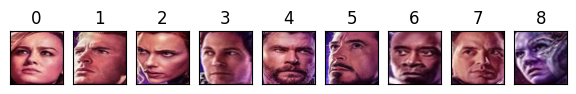

In [14]:
f = r'C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg'
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image

img,va = plot_result(f,[0,8,4],embedding_faces,position,m)
# img,va = plot_result(f,[0,8,4],embedding_faces,position,m)

In [15]:
img.show()

In [10]:
from PIL import Image, ImageDraw

# Load the image
input_image_path = "input_image.jpg"
output_image_path = "censored_image.jpg"
image = Image.open(input_image_path)

# Define the region to censor (coordinates of the top-left and bottom-right corners)
censor_region = (100, 200, 300, 400)  # Format: (left, top, right, bottom)

# Crop the censor region from the original image
censored_area = image.crop(censor_region)

# Get the size of the cropped region
censored_width, censored_height = censored_area.size

# Create a black box (pixelation) censor
pixel_size = 10  # Adjust this value for different levels of pixelation
censored_area = censored_area.resize(
    (censored_width // pixel_size, censored_height // pixel_size),
    Image.NEAREST
).resize(
    (censored_width, censored_height),
    Image.NEAREST
)

# Paste the censored area back onto the original image
image.paste(censored_area, censor_region)

# Save the modified image
image.save(output_image_path)

